In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
#mne.viz.set_3d_backend("notebook")

In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Joan Massich <mailsik@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause

import os.path as op
import numpy as np

import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects
0 files missing from bem.txt in /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage


In [3]:
FILE = 'S001R10.edf'

raw = mne.io.read_raw_edf(FILE, verbose=False, preload=True)
mne.datasets.eegbci.standardize(raw)  # set channel names
montage=mne.channels.make_standard_montage('standard_1020')
raw = raw.set_montage(montage); # set montage
raw = raw.set_eeg_reference(projection=True, verbose = False)

In [4]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem,  meg=False, eeg=True, verbose=False)
#fwd = mne.convert_forward_solution(fwd, force_fixed=True, verbose=False)

#fwd['src'][0]

In [5]:
def get_vertex_locations(fwd):
    fwd = fwd.copy()


    vertex_locations = []
    for s, _ in zip(fwd["src"], ("lh", "rh")):
        vertex_locations.append(s["rr"])
    
    n_vertices_lh = fwd['src'][0]['np']
    n_vertices_rh = fwd['src'][0]['np']
    vertex_locations = np.array(vertex_locations).reshape(n_vertices_lh+n_vertices_rh, 3)

    return vertex_locations

def get_triangles(fwd):
    fwd = fwd.copy()

    #triangles_lh = fwd['src'][0]['tris']
    #triangles_rh = fwd['src'][1]['tris'] + np.max(triangles_lh)

    #triangles = np.vstack((triangles_lh, triangles_rh))

    return fwd['src'][0]['tris'], fwd['src'][1]['tris']

def get_source_locations(fwd):
    return fwd['source_rr']


vertex_locations = get_vertex_locations(fwd)
source_locations = get_source_locations(fwd)
triangles = get_triangles(fwd)

In [6]:
L = fwd['sol']['data']
L.shape

(64, 61452)

In [7]:
fwd.keys()

dict_keys(['sol', 'source_ori', 'nsource', 'coord_frame', 'sol_grad', 'nchan', '_orig_source_ori', '_orig_sol', '_orig_sol_grad', 'info', 'src', 'source_nn', 'source_rr', 'surf_ori', 'mri_head_t'])

In [8]:
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: Average EEG reference: off
 sfreq: 160.0 Hz
>

In [9]:
F = raw.get_data()[:, :160] # first second of data
F.shape

(64, 160)

In [10]:
C = L.T@F
C.shape

(61452, 160)

In [11]:
C.T[0]

array([ 0.07261988, -0.0601709 , -0.10173054, ...,  0.05771949,
       -0.08183777, -0.13842957])

In [12]:
fwd.keys()

dict_keys(['sol', 'source_ori', 'nsource', 'coord_frame', 'sol_grad', 'nchan', '_orig_source_ori', '_orig_sol', '_orig_sol_grad', 'info', 'src', 'source_nn', 'source_rr', 'surf_ori', 'mri_head_t'])

In [13]:
fwd['src'][0]['rr'].shape

(163842, 3)

In [14]:
fwd['src'][0]['tris']

array([[     0,  40964,  40962],
       [     0,  40962,  40965],
       [     0,  40965,  40967],
       ...,
       [163841, 160926,  39990],
       [163113, 160926, 163841],
       [163113,     11, 160926]], dtype=int32)

In [15]:
from tqdm import tqdm

def get_mesh_neightbour_dict(mesh_data):
    neightbours_dict = {}
    for i in tqdm(range(20000)):
        neightbours = mesh_data[np.any(mesh_data == i, axis=1)].flatten()
        neightbours = np.unique(neightbours[neightbours != i])
        neightbours_dict[i] = neightbours
    return neightbours_dict

#get_mesh_neightbour_dict(fwd['src'][0]['tris'])

In [45]:
mne.datasets.fetch_aparc_sub_parcellation(subjects_dir=subjects_dir, verbose=True)

#labels = mne.read_labels_from_annot('fsaverage', 'HCPMMP1', 'lh', subjects_dir=subjects_dir)
labels = mne.read_labels_from_annot(subject)

#labs, _ = mne.stc_to_label(stc, fwd['src'])

Reading labels from parcellation...
   read 35 labels from /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/label/rh.aparc.annot


In [48]:
stc_label = stc.in_label(labels[0])

In [54]:
stc_label.data.shape

(134, 1600)

In [58]:
np.sum(stc.data, axis)

21157478.551872488

In [51]:
labels[0].vertices

array([   129,    133,    289, ..., 157244, 157245, 157246])

In [17]:
print(vertex_locations.shape)
print(source_locations.shape)

(327684, 3)
(20484, 3)


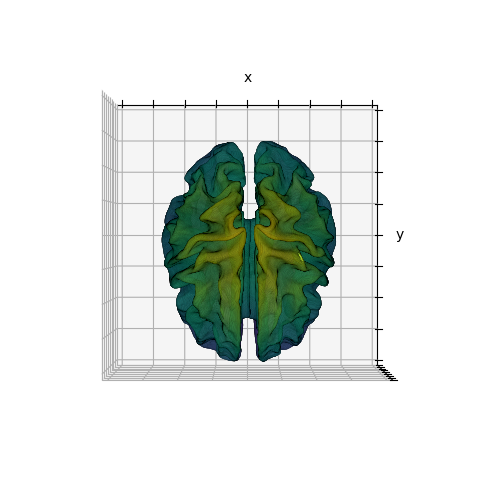

In [18]:
fig = plt.figure(figsize=(18,6))

#views = [(90,90), (0,0), (0,90)]
views = [(90,90)]

n_plots = len(views)

#for plot_idx in range(n_plots):

ax = fig.add_subplot(1, n_plots, 1, projection='3d')

ax.plot_trisurf(*fwd['src'][0]['rr'].T, triangles=fwd['src'][0]['tris'], linewidth=0.1, shade=False, cmap='viridis', antialiased=True, edgecolor=(0,0,0,0.5))
ax.plot_trisurf(*fwd['src'][1]['rr'].T, triangles=fwd['src'][1]['tris'], linewidth=0.1, shade=False, cmap='viridis', antialiased=True, edgecolor=(0,0,0,0.5))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_zlim(-0.05, 0.15)
ax.set_box_aspect([1,1,1])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(90, 90)

#ax.dist = 8
ax.xaxis.labelpad = -2
ax.yaxis.labelpad = -5


In [ ]:
np.max(fwd['src'][0]['tris'] + 163841)

In [ ]:
np.max(fwd['src'][0]['tris'])

In [ ]:
vertex_locations.shape

In [ ]:
C.T.shape

In [32]:
src

'/home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/bem/fsaverage-ico-5-src.fif'

In [30]:
tmin = 0
tmax = 10
imin = int(0 * raw.info['sfreq'])
imax = int(10 * raw.info['sfreq'])

cov = mne.compute_raw_covariance(raw, verbose=False, tmin=tmin, tmax=tmax)


snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr ** 2
method = "sLORETA"


inv = mne.minimum_norm.make_inverse_operator(
    raw.info, fwd, cov, verbose=True)

stc = mne.minimum_norm.apply_inverse_raw(raw, inv, lambda2, method=method, start=imin, stop=imax, verbose=0)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.174517
    scale = 125525 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.3e+02  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [35]:
fwd['src']

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>

-- number of adjacent vertices : 20484


In [44]:
labs.#

<Label | fsaverage, unnamed, lh : 163842 vertices>

In [21]:
d = stc.data
d.shape

(20484, 1600)

In [27]:
def plot_sources(source_locations, source_estimates, time_idx=0, views = [(90,90), (0,0)], save_fig=False):
    #views = [(90,90), (0,0), (0,90), (0, 180)]
    n_plots = len(views)

    fig = plt.figure(figsize=(12,8), dpi=200)

    for plot_idx in range(n_plots):
        ax = fig.add_subplot(1, n_plots, plot_idx+1, projection='3d')
        ax.scatter3D(source_locations[:,0], source_locations[:,1], source_locations[:,2], s=20, c=source_estimates[time_idx])

        ax.view_init(views[plot_idx][0], views[plot_idx][1])

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

    time = np.round(time_idx / 160, 3)
    fig.suptitle(f'Time: {time} s.', fontsize=16, y=.75)

    if save_fig:
        plt.savefig(f'Source Estimates/source_estimate{time_idx}', bbox_inches='tight', transparent=True)

    plt.tight_layout(pad=-10)
    plt.show()

In [28]:
from tqdm import trange

for i in trange(1000):
    i = 1

100%|██████████| 1000/1000 [00:00<00:00, 704333.17it/s]


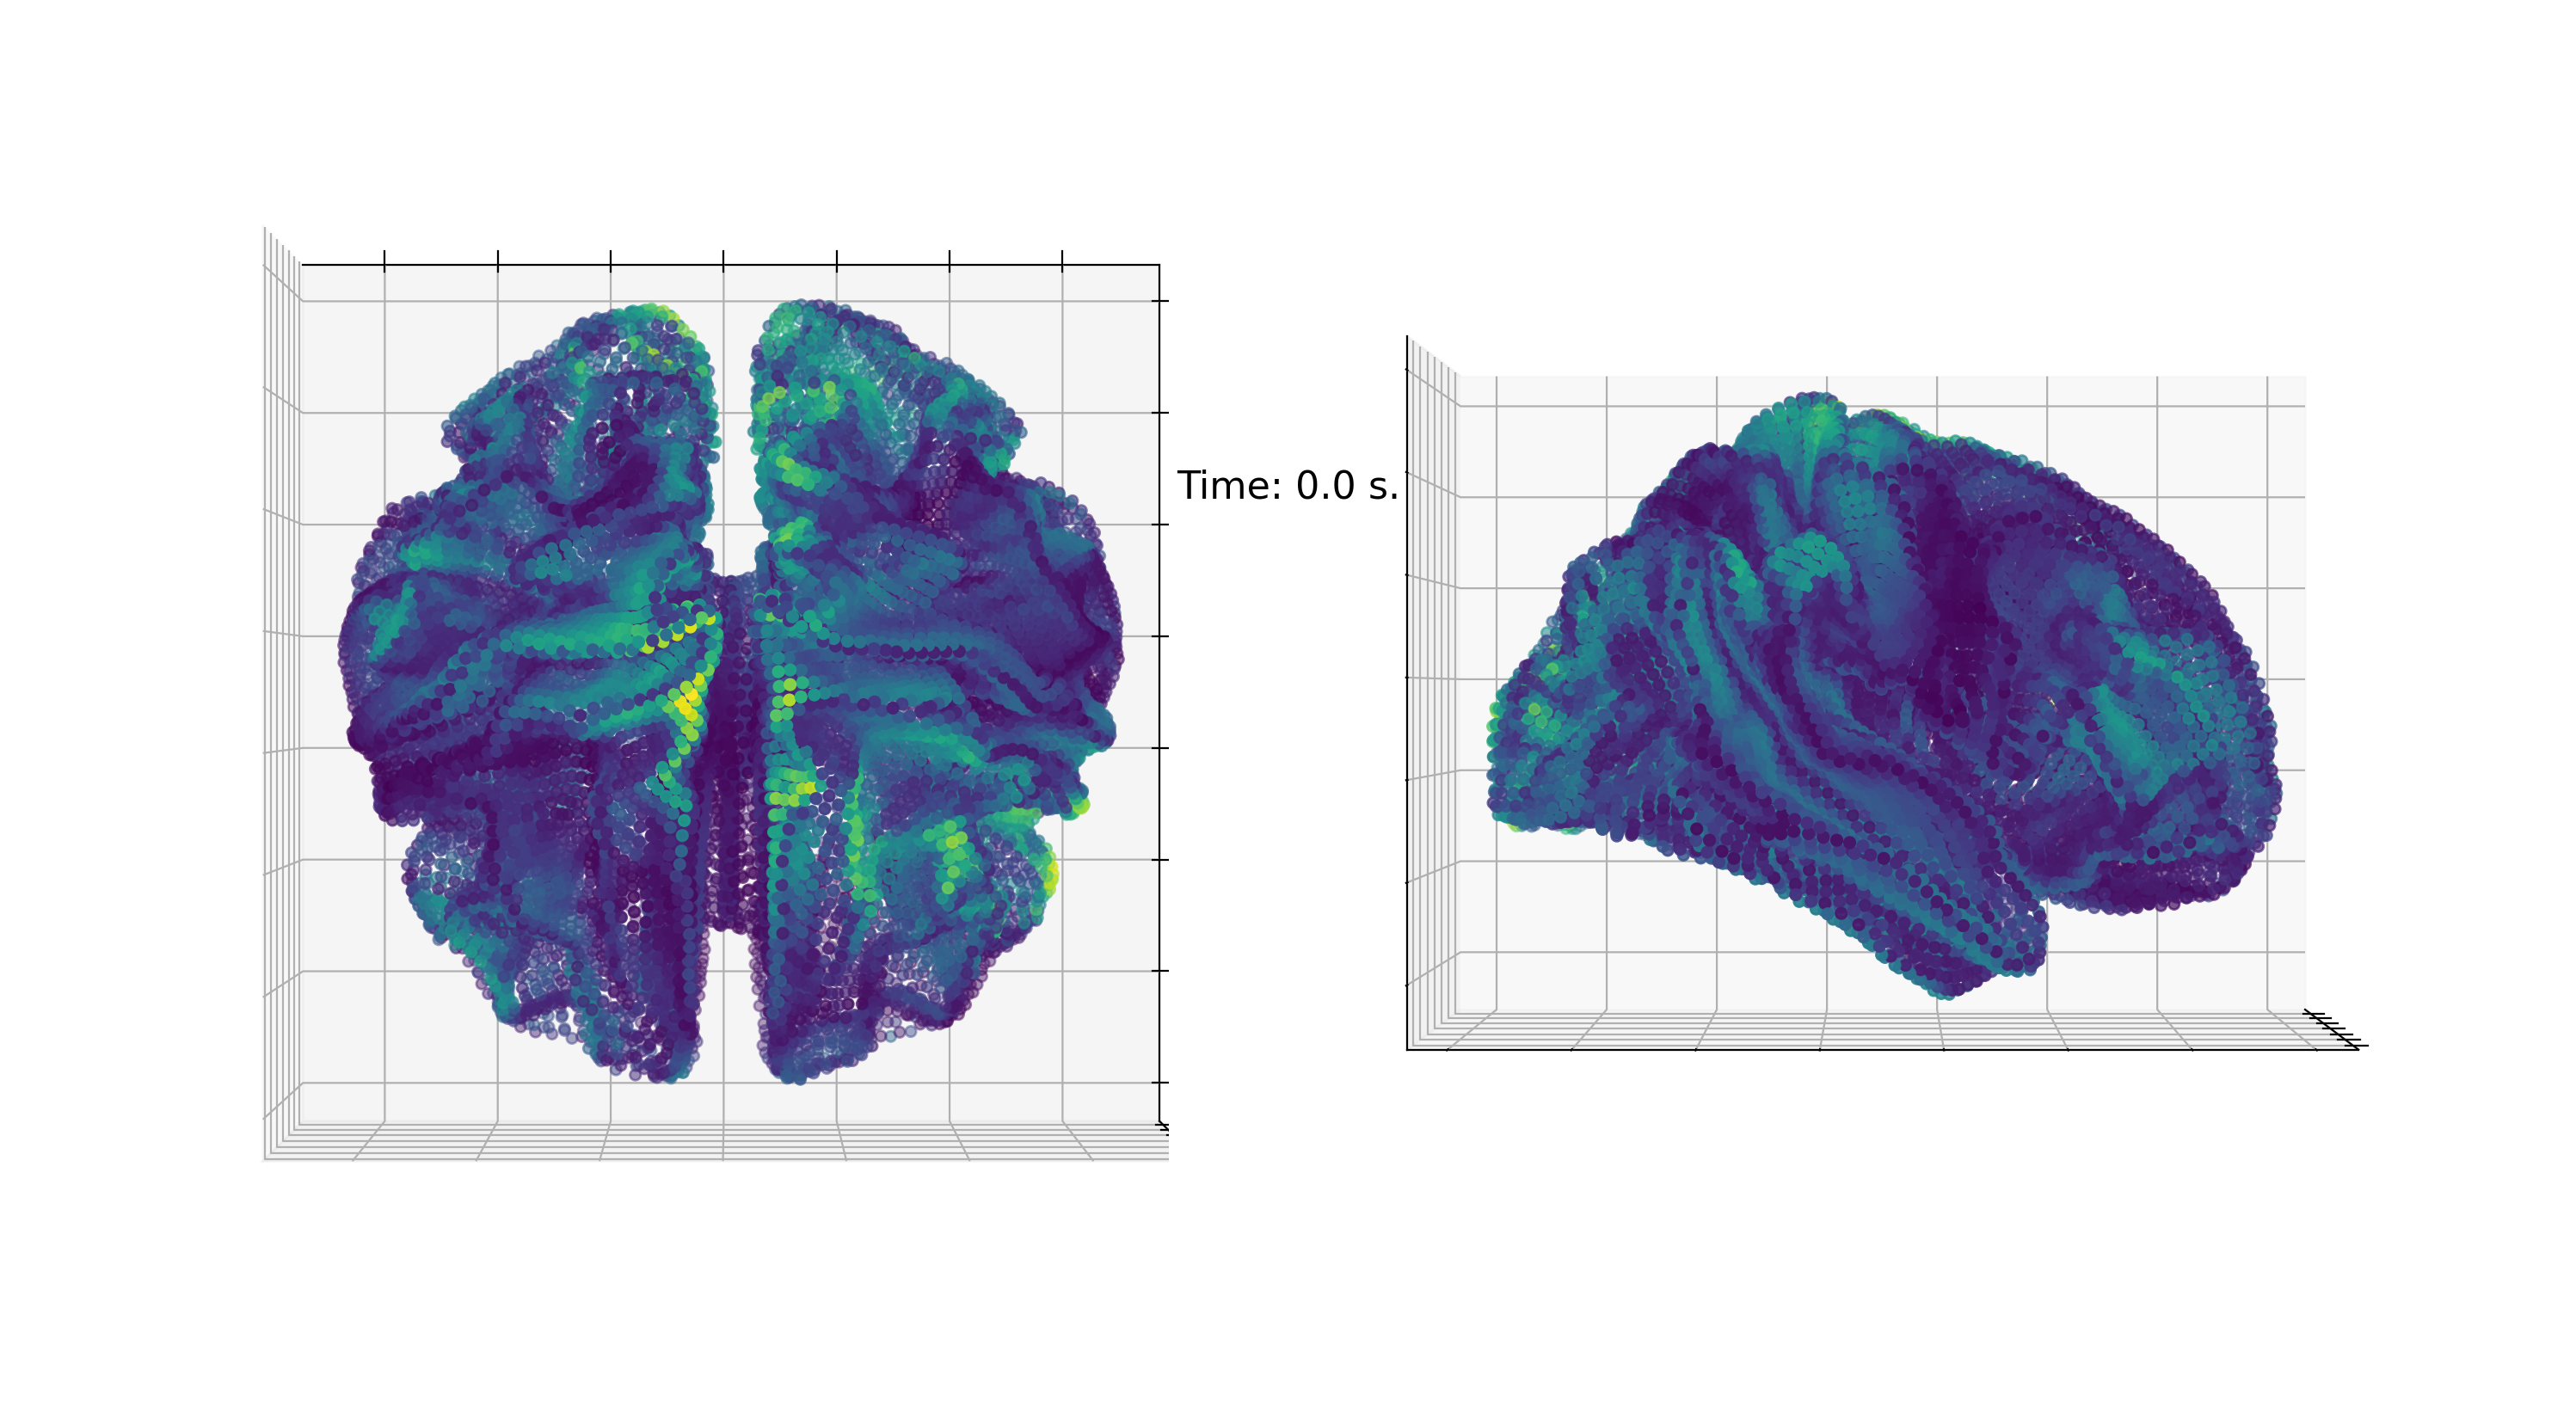

In [29]:
#for idx in trange(stc.data.shape[1]):
 #   plot_sources(source_locations, stc.data.T, time_idx=idx, views = [(90,90), (0,0)], save_fig=True)

plot_sources(source_locations, stc.data.T, time_idx=0, views = [(90,90), (0,0)], save_fig=True)


In [ ]:
fig = plt.figure(figsize=(12,8))

n_plots = 2
views = [(0,0), (0,90)]

colormap = [plt.get_cmap('tab20')(x) for x in np.linspace(0,1,20)]

for plot_idx in range(n_plots):
    
    ax = fig.add_subplot(1, n_plots, plot_idx+1, projection='3d')
    #ax.scatter3D(vertex_locations[:,0], vertex_locations[:,1], vertex_locations[:,2], s=.01)
    for idx, label in enumerate(labels): 
        region_locations = vertex_locations[label.get_vertices_used()]
        #ax.scatter3D(region_locations[:,0], region_locations[:,1], region_locations[:,2], s=.5, color=colormap[idx%20], label=label.name)
        ax.scatter3D(region_locations[:,0], region_locations[:,1], region_locations[:,2], s=50)#, color='blue', label=label.name)

    #ax.set_xlim(-.08, .07)
    #ax.set_ylim(-.1, -.1)
    #ax.set_zlim(-.01, -.1)

    ax.view_init(views[plot_idx][0], views[plot_idx][1])

plt.tight_layout()
plt.show()

In [ ]:
vertex_locations[labels[5].vertices].shape

In [ ]:
fig, ax = plt.subplots(1, 1)
im, _ = mne.viz.plot_topomap(L.T[9], raw.info, axes=ax, show=False)

In [ ]:
raw.compute_psd().plot_topomap();

In [ ]:
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir, add_dist=False, verbose=False)

mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', src=src, orientation='coronal')

In [ ]:
mne.SourceEstimate(raw.get_data(), [0, 1], 0, 1)